In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
import os
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from fastai.vision import *
from keras import applications
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam

In [ ]:
from google.colab import files #rerun cell if run into error
files.upload() #upload kaggle.json

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download andrewmvd/ocular-disease-recognition-odir5k --unzip

100% 1.62G/1.62G [00:15<00:00, 136MB/s]
100% 1.62G/1.62G [00:15<00:00, 111MB/s]


In [ ]:
%ls

full_df.csv  kaggle.json  ODIR-5K/  preprocessed_images/  sample_data/


In [ ]:
os.chdir('/content')

In [ ]:
data = pd.read_csv('full_df.csv')
data = data.drop(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels'], axis = 1)
data.head()

,target,filename
0,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
dmmy = pd.get_dummies(data.target)
dmmy = dmmy.rename(columns = {'[0, 0, 0, 0, 0, 0, 0, 1]' : 'O', '[0, 0, 0, 0, 0, 0, 1, 0]' : 'M', '[0, 0, 0, 0, 0, 1, 0, 0]' : 'H', '[0, 0, 0, 0, 1, 0, 0, 0]' : 'A', '[0, 0, 0, 1, 0, 0, 0, 0]' : 'C', '[0, 0, 1, 0, 0, 0, 0, 0]' : 'G', '[0, 1, 0, 0, 0, 0, 0, 0]' : 'D', '[1, 0, 0, 0, 0, 0, 0, 0]' : 'N'})
dmmy

,O,M,H,A,C,G,D,N
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
6387,0,0,0,0,0,0,1,0
6388,0,0,0,0,0,0,1,0
6389,0,0,0,0,0,0,1,0
6390,0,0,0,0,0,0,1,0


In [ ]:
data = pd.concat([data, dmmy], axis = 1)
data = data.drop(['target'], axis = 1)
data.head()

,filename,O,M,H,A,C,G,D,N
0,0_right.jpg,0,0,0,0,0,0,0,1
1,1_right.jpg,0,0,0,0,0,0,0,1
2,2_right.jpg,0,0,0,0,0,0,1,0
3,4_right.jpg,0,0,0,0,0,0,1,0
4,5_right.jpg,0,0,0,0,0,0,1,0


In [ ]:
y = data.drop(['filename'], axis = 1)
x = data.drop(['O', 'M', 'H', 'A', 'C', 'G', 'D', 'N'], axis = 1)

In [ ]:
y.sum(axis = 0)

O     708
M     232
H     128
A     266
C     293
G     284
D    1608
N    2873
dtype: int64

In [ ]:
y.sum(axis = 0).max()/y.sum(axis = 0)

O     4.057910
M    12.383621
H    22.445312
A    10.800752
C     9.805461
G    10.116197
D     1.786692
N     1.000000
dtype: float64

In [ ]:
tfms = get_transforms(do_flip = True, max_lighting = 0.3, max_warp = 0, max_rotate = 360, max_zoom = 0)
len(tfms)

2

In [ ]:
fact = round(y.sum(axis = 0).max()/y.sum(axis = 0))
fact

O     4.0
M    12.0
H    22.0
A    11.0
C    10.0
G    10.0
D     2.0
N     1.0
dtype: float64

In [ ]:
fact = fact -1

In [ ]:
lens = list(y.sum(axis= 0))
del lens[-1]
lens

[708, 232, 128, 266, 293, 284, 1608]

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
%%time
os.chdir('/content/preprocessed_images')
for cls in trange(0, len(fact) - 1) :
  for rep in trange(0, int(fact[cls])) :
    for i in trange(0, lens[cls]) :
      im = open_image(x['filename'][y[fact.index[cls]]== 1].iloc[i])
      new = im.apply_tfms(tfms[0], padding_mode = 'zeros')
      name = str(rep) + 'rep' + x['filename'][y[fact.index[cls]] == 1].iloc[i]
      new.save(name)
      att = y[x['filename'] == x['filename'][y[fact.index[cls]]== 1].iloc[i]]
      att['filename'] = name
      x = pd.concat([x, att], join = 'inner')
      y = pd.concat([y, att], join = 'inner')




CPU times: user 14min 57s, sys: 14 s, total: 15min 11s
Wall time: 15min 9s


In [ ]:
y.sum(axis = 0).max()/y.sum(axis = 0)

O    1.135593
M    1.155172
H    1.142045
A    1.099111
C    1.097611
G    1.132394
D    1.000000
N    1.119387
dtype: float64

In [ ]:
y.sum(axis = 0)

O    2832
M    2784
H    2816
A    2926
C    2930
G    2840
D    3216
N    2873
dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.90, random_state = 42, stratify = y)

In [ ]:
print(y_train.sum(axis = 0)/y.sum(axis = 0))

O    0.900071
M    0.900144
H    0.899858
A    0.899863
C    0.900000
G    0.900000
D    0.899876
N    0.900104
dtype: float64


In [ ]:
print(y_train.sum(axis = 0)) 

O    2549
M    2506
H    2534
A    2633
C    2637
G    2556
D    2894
N    2586
dtype: int64


In [ ]:
print(y_test.sum(axis = 0))

O    283
M    278
H    282
A    293
C    293
G    284
D    322
N    287
dtype: int64


In [ ]:
def _parse_function(filename, label) :
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels = 3)
  image = tf.cast(image_decoded, tf.float32)
  return image, label

In [ ]:
%%time
at = tf.data.experimental.AUTOTUNE
tr_lbl = tf.constant(y_train)
os.chdir('/content/preprocessed_images')
tr_set = tf.data.Dataset.from_tensor_slices((x_train['filename'], tr_lbl))
tr_set = tr_set.map(_parse_function, num_parallel_calls = at)
tr_set = tr_set.batch(2)
iterator = tf.compat.v1.data.make_one_shot_iterator(tr_set)
images, labels = iterator.get_next()
os.chdir('/content')

CPU times: user 546 ms, sys: 309 ms, total: 855 ms
Wall time: 5.62 s


In [ ]:
%%time
at = tf.data.experimental.AUTOTUNE
ts_lbl = tf.constant(y_test)
os.chdir('/content/preprocessed_images')
ts_set = tf.data.Dataset.from_tensor_slices((x_test['filename'], ts_lbl))
ts_set = ts_set.map(_parse_function, num_parallel_calls = at)
ts_set = ts_set.batch(2)
iterator = tf.compat.v1.data.make_one_shot_iterator(ts_set)
images, labels = iterator.get_next()
os.chdir('/content')

CPU times: user 32 ms, sys: 3.99 ms, total: 36 ms
Wall time: 28.7 ms


In [ ]:
base_model = applications.resnet50.ResNet50(weights = None, include_top = False, input_shape= (512, 512, 3))

In [ ]:
w = base_model.output
w = GlobalAveragePooling2D()(w)
w = Dropout(0.7)(w)
predictions = Dense(8, activation= 'softmax')(w)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
adam = Adam(lr=0.0001)
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes = 8)])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
print(x_train.shape, x_test.shape)

(20895, 1) (2322, 1)


In [ ]:
%%time
os.chdir('/content/preprocessed_images')
history = model.fit(tr_set.repeat(), epochs = 100, batch_size = 64, steps_per_epoch = 326, validation_data = ts_set.repeat(), validation_batch_size = 64, validation_steps = 36, use_multiprocessing = True)

Epoch 1/100
326/326 [==============================] - 98s 300ms/step - loss: 2.9884 - accuracy: 0.1442 - f1_score: 0.1429 - val_loss: 2.2122 - val_accuracy: 0.2500 - val_f1_score: 0.1446
Epoch 2/100
326/326 [==============================] - 96s 296ms/step - loss: 2.3497 - accuracy: 0.1610 - f1_score: 0.1588 - val_loss: 2.0015 - val_accuracy: 0.3056 - val_f1_score: 0.1730
Epoch 3/100
326/326 [==============================] - 96s 295ms/step - loss: 2.2482 - accuracy: 0.1687 - f1_score: 0.1579 - val_loss: 1.9441 - val_accuracy: 0.2639 - val_f1_score: 0.1337
Epoch 4/100
326/326 [==============================] - 97s 296ms/step - loss: 2.2110 - accuracy: 0.1518 - f1_score: 0.1466 - val_loss: 2.0481 - val_accuracy: 0.2639 - val_f1_score: 0.1834
Epoch 5/100
326/326 [==============================] - 96s 295ms/step - loss: 2.3339 - accuracy: 0.1779 - f1_score: 0.1730 - val_loss: 5.1715 - val_accuracy: 0.2917 - val_f1_score: 0.1638
Epoch 6/100
326/326 [==============================] - 96s 2

In [ ]:
d = history.history['loss']
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = history.history['val_loss']
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 2.1233178057056845 Train slope: -0.00810485002123985
Test intercept: 2.6848082787211576 Test slope: -0.005606488616410013


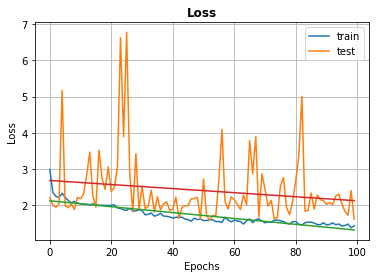

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('Loss', fontweight = 'bold')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('loss.pdf')
plt.show()

In [ ]:
d = history.history['accuracy']
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = history.history['val_accuracy']
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.20337795806698278 Train slope: 0.0027393300158463185
Test intercept: 0.2561276134214189 Test slope: 0.0014558955753865344


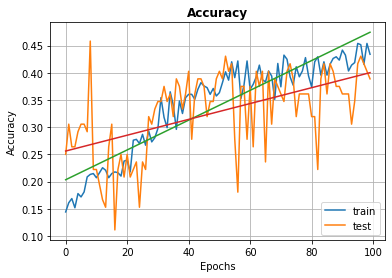

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('Accuracy', fontweight = 'bold')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig('accuracy.pdf')
plt.show()

In [ ]:
f1_o = []
f1_m = []
f1_h = []
f1_a = []
f1_c = []
f1_g = []
f1_d = []
f1_n = []
for c in trange(0, 8) : #classes
  for e in trange(0, 100) : #epochs
    if c == 0 :
      f1_o.append(history.history['f1_score'][e][c])
    elif c == 1 :
      f1_m.append(history.history['f1_score'][e][c])
    elif c == 2 :
      f1_h.append(history.history['f1_score'][e][c])
    elif c == 3 :
      f1_a.append(history.history['f1_score'][e][c])
    elif c == 4 :
      f1_c.append(history.history['f1_score'][e][c])
    elif c == 5 :
      f1_g.append(history.history['f1_score'][e][c])
    elif c == 6 :
      f1_d.append(history.history['f1_score'][e][c])
    elif c == 7 :
      f1_n.append(history.history['f1_score'][e][c])

In [ ]:
vf1_o = []
vf1_m = []
vf1_h = []
vf1_a = []
vf1_c = []
vf1_g = []
vf1_d = []
vf1_n = []
for c in trange(0, 8) : #classes
  for e in trange(0, 100) : #epochs
    if c == 0 :
      vf1_o.append(history.history['val_f1_score'][e][c])
    elif c == 1 :
      vf1_m.append(history.history['val_f1_score'][e][c])
    elif c == 2 :
      vf1_h.append(history.history['val_f1_score'][e][c])
    elif c == 3 :
      vf1_a.append(history.history['val_f1_score'][e][c])
    elif c == 4 :
      vf1_c.append(history.history['val_f1_score'][e][c])
    elif c == 5 :
      vf1_g.append(history.history['val_f1_score'][e][c])
    elif c == 6 :
      vf1_d.append(history.history['val_f1_score'][e][c])
    elif c == 7 :
      vf1_n.append(history.history['val_f1_score'][e][c])

In [ ]:
d = f1_o
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_o
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.11271412080430451 Train slope: 2.641860390081441e-05
Test intercept: 0.03261116909803734 Test slope: 0.0004262870378924169


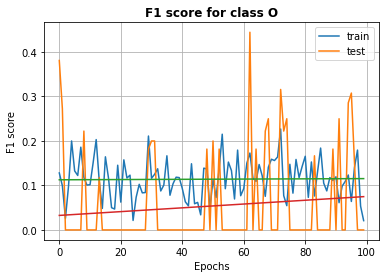

In [ ]:
plt.plot(f1_o, label='train')
plt.plot(vf1_o, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class O', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_o.pdf')
plt.show()

In [ ]:
d = f1_m
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_m
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.4429189451761764 Train slope: 0.0048444094667376035
Test intercept: 0.4147601422623241 Test slope: 0.0027479518589639397


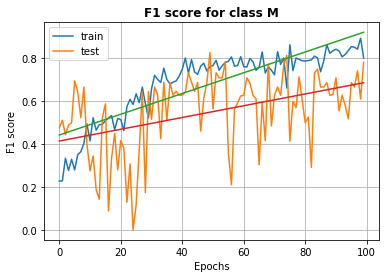

In [ ]:
plt.plot(f1_m, label='train')
plt.plot(vf1_m, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class M', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_m.pdf')
plt.show()

In [ ]:
d = f1_h
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_h
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.10874838457691793 Train slope: 0.0028923511623155946
Test intercept: 0.09374241087548803 Test slope: 0.0013236323864546542


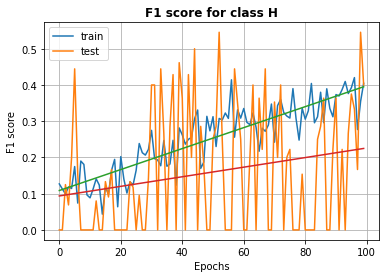

In [ ]:
plt.plot(f1_h, label='train')
plt.plot(vf1_h, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class H', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_h.pdf')
plt.show()

In [ ]:
d = f1_a
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_a
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.11600223551882378 Train slope: 0.0015737665129644952
Test intercept: 0.08962529752219076 Test slope: 0.0019316064491488002


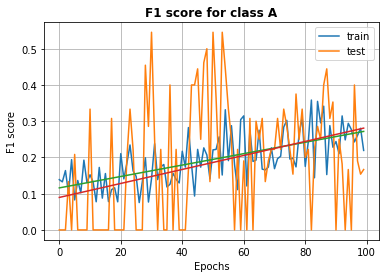

In [ ]:
plt.plot(f1_a, label='train')
plt.plot(vf1_a, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class A', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_a.pdf')
plt.show()

In [ ]:
d = f1_c
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_c
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.25829788991425306 Train slope: 0.007005659906026517
Test intercept: 0.08580645183820537 Test slope: 0.004825721880783735


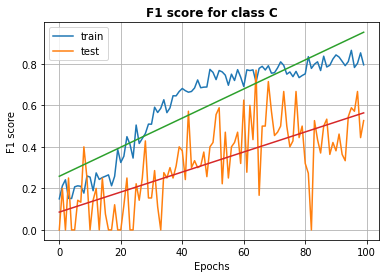

In [ ]:
plt.plot(f1_c, label='train')
plt.plot(vf1_c, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class C', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_c.pdf')
plt.show()

In [ ]:
d = f1_g
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_g
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.19474125126210767 Train slope: 0.002459734887143996
Test intercept: 0.4577903381108057 Test slope: -0.0007471966264199972


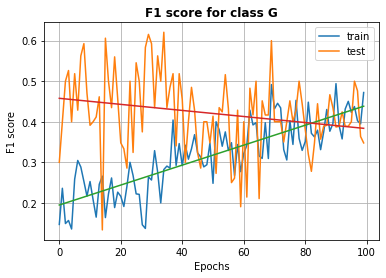

In [ ]:
plt.plot(f1_g, label='train')
plt.plot(vf1_g, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class G', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_g.pdf')
plt.show()

In [ ]:
d = f1_d
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_d
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.15678735143624908 Train slope: 0.0011524925074025097
Test intercept: 0.09616880446819973 Test slope: 8.047731684343695e-05


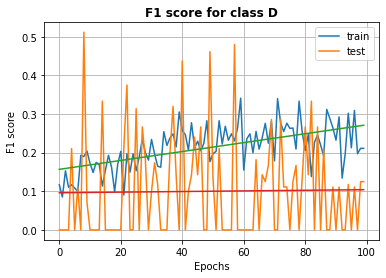

In [ ]:
plt.plot(f1_d, label='train')
plt.plot(vf1_d, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class D', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_d.pdf')
plt.show()

In [ ]:
d = f1_n
ep = history.epoch
(m, b) = np.polyfit(ep, d, 1)
yp = np.polyval([m, b], ep)
print('Train intercept:', b, 'Train slope:', m)
d2 = vf1_n
ep2 = history.epoch
(m, b) = np.polyfit(ep2, d2, 1)
yp2 = np.polyval([m, b], ep2)
print('Test intercept:', b, 'Test slope:', m)

Train intercept: 0.1186803030436582 Train slope: 0.0017749823764762354
Test intercept: 0.023628753016490735 Test slope: 0.0034056068090858884


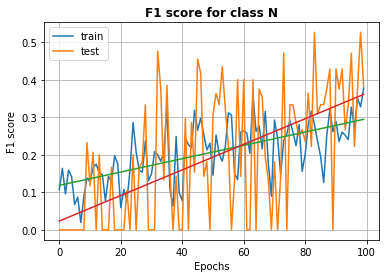

In [ ]:
plt.plot(f1_n, label='train')
plt.plot(vf1_n, label='test')
plt.plot(ep, yp)
plt.plot(ep2, yp2)
plt.legend()
plt.title('F1 score for class N', fontweight = 'bold')
plt.grid(True)
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.savefig('f1_n.pdf')
plt.show()

In [ ]:
files.download('loss.pdf')
files.download('accuracy.pdf')
files.download('f1_o.pdf')
files.download('f1_h.pdf')
files.download('f1_m.pdf')
files.download('f1_a.pdf')
files.download('f1_c.pdf')
files.download('f1_g.pdf')
files.download('f1_d.pdf')
files.download('f1_n.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>